In [1]:
%reset -f

In [2]:
from IPython.core.interactiveshell import InteractiveShell # type: ignore
InteractiveShell.ast_node_interactivity = 'none' # 'last_expr' # Настраиваем отображение всех результатов в ячейке

In [21]:
import polars as pl
import pandas as pd
# Загружаем данные
df = pl.read_parquet("transaction_fraud_data.parquet")

# Целевое количество строк
target_rows = 100_000

# Получаем уникальные классы и их количество
counts = df.select([
    pl.col("is_fraud"),
    pl.count().over("is_fraud").alias("count")
]).unique()

# Создаём сэмпл по классам пропорционально
sample = pl.concat([
    df.filter(pl.col("is_fraud") == cls).sample(int(target_rows * count / df.shape[0]), seed=42)
    for cls, count in zip(counts["is_fraud"], counts["count"])
])

print(sample.shape)
df = sample.to_pandas()
print(df['is_fraud'].value_counts(normalize=True))

C:\Users\blue\AppData\Local\Temp\ipykernel_6368\218236445.py:12: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().over("is_fraud").alias("count")


(99999, 23)
is_fraud
False    0.800278
True     0.199722
Name: proportion, dtype: float64


In [ ]:
import pandas as pd
import numpy as np

# Раскладываем колонку "last_hour_activity" в отдельные столбцы
activity_df = df["last_hour_activity"].apply(pd.Series)

# Переименуем столбцы для наглядности
activity_df = activity_df.rename(columns={
    "num_transactions": "last_hour_num_transactions",
    "total_amount": "last_hour_total_amount",
    "unique_merchants": "last_hour_unique_merchants",
    "unique_countries": "last_hour_unique_countries",
    "max_single_amount": "last_hour_max_single_amount"
})

# Объединяем обратно с основным df
df = pd.concat([df.drop(columns=["last_hour_activity"]), activity_df], axis=1)

# Загружаем курсы валют
df_cr = pd.read_parquet(
    "historical_currency_exchange.parquet",
    engine="pyarrow"
)

print(df.shape)
print(df_cr.shape)


(99999, 27)
(31, 12)


In [23]:
import pandas as pd
import numpy as np

# Преобразуем даты
df_cr['date'] = pd.to_datetime(df_cr['date'])  # курс
df['transaction_date'] = pd.to_datetime(df['timestamp']).dt.floor('D')  # дата транзакции без времени

# Получаем список валют
currency_cols = [c for c in df_cr.columns if c != 'date']

# "Разворачиваем" df_cr в столбцы: date | currency | rate
df_rates = df_cr.melt(id_vars='date', value_vars=currency_cols,
                      var_name='currency', value_name='rate')

# Объединяем по дате и валюте
df = df.merge(df_rates, how='left',
              left_on=['transaction_date', 'currency'],
              right_on=['date', 'currency'])

# Если курс для даты отсутствует, берем последний доступный курс для валюты
last_rates = df_rates.groupby('currency')['rate'].last().to_dict()
df['rate'] = df['rate'].fillna(df['currency'].map(last_rates))

# Конвертируем суммы в USD
df['amount_usd'] = df['amount'] / df['rate']
df['last_hour_total_amount_usd'] = df['last_hour_total_amount'] / df['rate']
df['last_hour_max_single_amount_usd'] = df['last_hour_max_single_amount'] / df['rate']

# # Убираем временные колонки
# df.drop(columns=['transaction_date', 'date', 'rate'], inplace=True)


In [ ]:
print("Всего полных дубликатов по строкам:", df.duplicated().sum())


Всего полных дубликатов по строкам: 0


In [25]:
num_rows_with_nan = df.isnull().any(axis=1).sum()
print("Всего уникальных строк с NaN:", num_rows_with_nan)

Всего уникальных строк с NaN: 0


In [26]:
print(df.dtypes)
print(df.dtypes.value_counts())

transaction_id                             object
customer_id                                object
card_number                                 int64
timestamp                          datetime64[us]
vendor_category                            object
vendor_type                                object
vendor                                     object
amount                                    float64
currency                                   object
country                                    object
city                                       object
city_size                                  object
card_type                                  object
is_card_present                              bool
device                                     object
channel                                    object
device_fingerprint                         object
ip_address                                 object
is_outside_home_country                      bool
is_high_risk_vendor                          bool


In [27]:
# Проверка пропущенных значений для каждого столбца
missing_values = df.isnull().sum()

missing_percent = (missing_values / len(df)) * 100  # Вычисляем процент пропусков
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})

# Фильтруем только те столбцы, где есть пропуски
missing_info = missing_info[missing_info['Missing Values'] > 0]
print(missing_info)


Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


In [28]:
print(df.info()) # Ещё раз проверка данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   transaction_id                   99999 non-null  object        
 1   customer_id                      99999 non-null  object        
 2   card_number                      99999 non-null  int64         
 3   timestamp                        99999 non-null  datetime64[us]
 4   vendor_category                  99999 non-null  object        
 5   vendor_type                      99999 non-null  object        
 6   vendor                           99999 non-null  object        
 7   amount                           99999 non-null  float64       
 8   currency                         99999 non-null  object        
 9   country                          99999 non-null  object        
 10  city                             99999 non-null  object   

In [29]:
ratio = df["is_fraud"].value_counts(normalize=True) * 100
print(ratio)


is_fraud
False    80.0278
True     19.9722
Name: proportion, dtype: float64



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


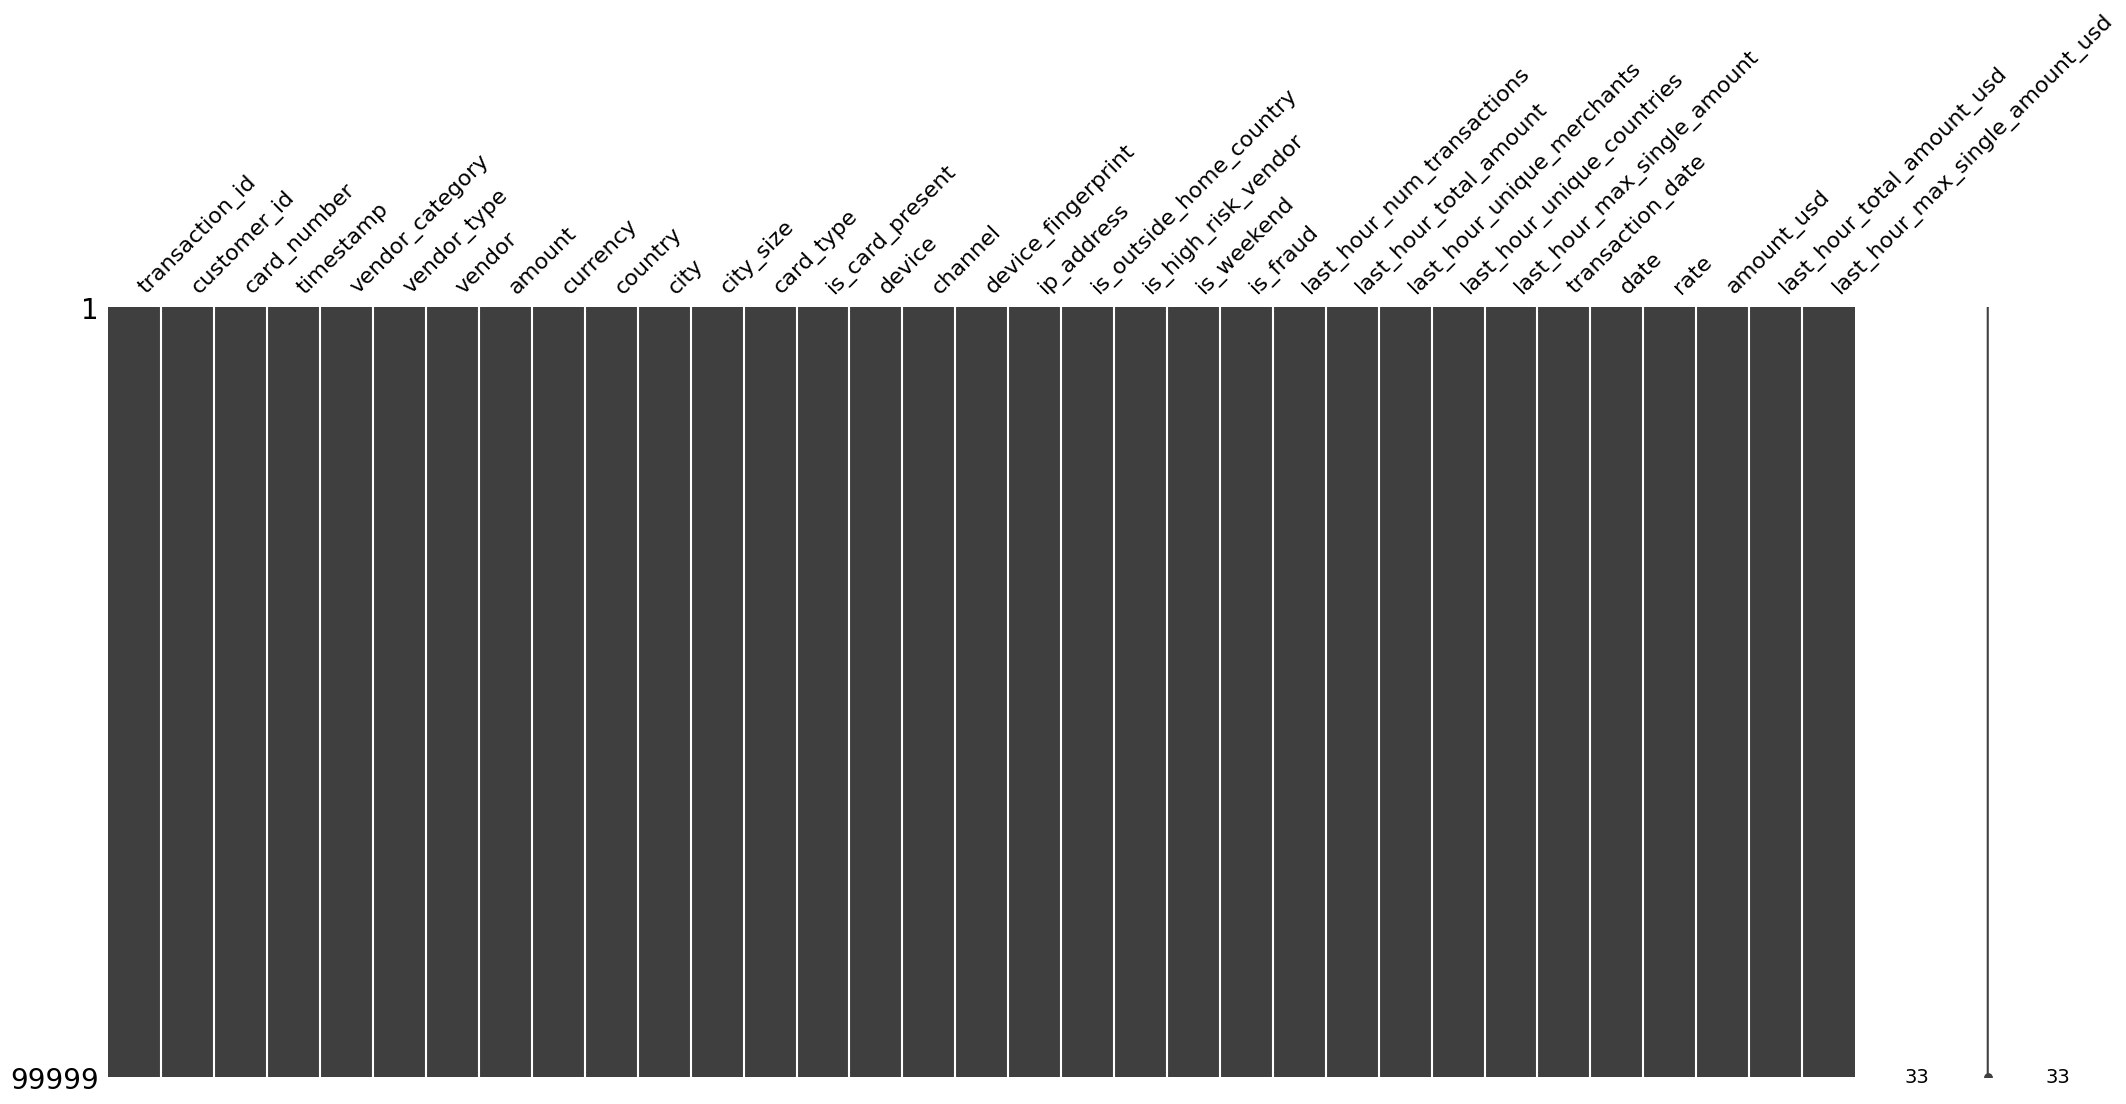

<Figure size 1500x900 with 0 Axes>

In [30]:
%pip install matplotlib
import matplotlib.pyplot as plt
import missingno as msno # type: ignore

msno.matrix(df)
plt.figure(figsize = (15,9))
plt.show()

#### Поиск категориальных выбросов. Частотный анализ

Визуализация. Возьмем только категориальные признаки.

In [31]:
category_percent_dict = {}
outliers_dict = {}
threshold = 1

cat_cols = df.select_dtypes(include=["object", "bool"]).drop(columns=['customer_id', 'transaction_id', 'ip_address', 'device_fingerprint'])
cat_cols = cat_cols.columns.tolist()

for col in cat_cols:
    category_percent = df[col].value_counts(normalize=True) * 100
    category_percent = category_percent.round(2)

    category_percent_list = [(index, percent) for index, percent in category_percent.items()]
    category_percent_dict[col] = category_percent_list

    outliers = []
    for index, percent in category_percent.items():
        if percent < threshold:
            outliers.append((index, percent))
            print(f"Выброс в {col}: {index} - {percent:.2f}%")

    if outliers:
        outliers_dict[col] = outliers

Выброс в vendor: Etsy - 0.93%
Выброс в vendor: Kroger - 0.92%
Выброс в vendor: eBay - 0.92%
Выброс в vendor: Amazon - 0.91%
Выброс в vendor: Shopify Store - 0.90%
Выброс в vendor: Food Lion - 0.90%
Выброс в vendor: Safeway - 0.89%
Выброс в vendor: Whole Foods - 0.89%
Выброс в vendor: Publix - 0.88%
Выброс в vendor: Wayfair - 0.87%
Выброс в vendor: Aldi - 0.87%
Выброс в vendor: Xbox Live - 0.87%
Выброс в vendor: AliExpress - 0.85%
Выброс в vendor: Nintendo eShop - 0.85%
Выброс в vendor: AMC Theaters - 0.85%
Выброс в vendor: Newegg - 0.84%
Выброс в vendor: Epic Games - 0.84%
Выброс в vendor: Ticketmaster - 0.84%
Выброс в vendor: TGI Fridays - 0.84%
Выброс в vendor: Trader Joe's - 0.83%
Выброс в vendor: LiveNation - 0.82%
Выброс в vendor: Red Lobster - 0.82%
Выброс в vendor: Home Depot - 0.82%
Выброс в vendor: PlayStation Store - 0.82%
Выброс в vendor: Olive Garden - 0.81%
Выброс в vendor: Walmart - 0.81%
Выброс в vendor: StubHub - 0.81%
Выброс в vendor: Applebee's - 0.81%
Выброс в vendor

#### Поиск числовых выбросов


In [32]:
import scipy.stats as stats

digit_columns = df.select_dtypes(include=['int64', 'float64']).columns
df_digit = df[digit_columns]
df_digit_corr = df_digit.copy()
print(df_digit.shape[1])


11


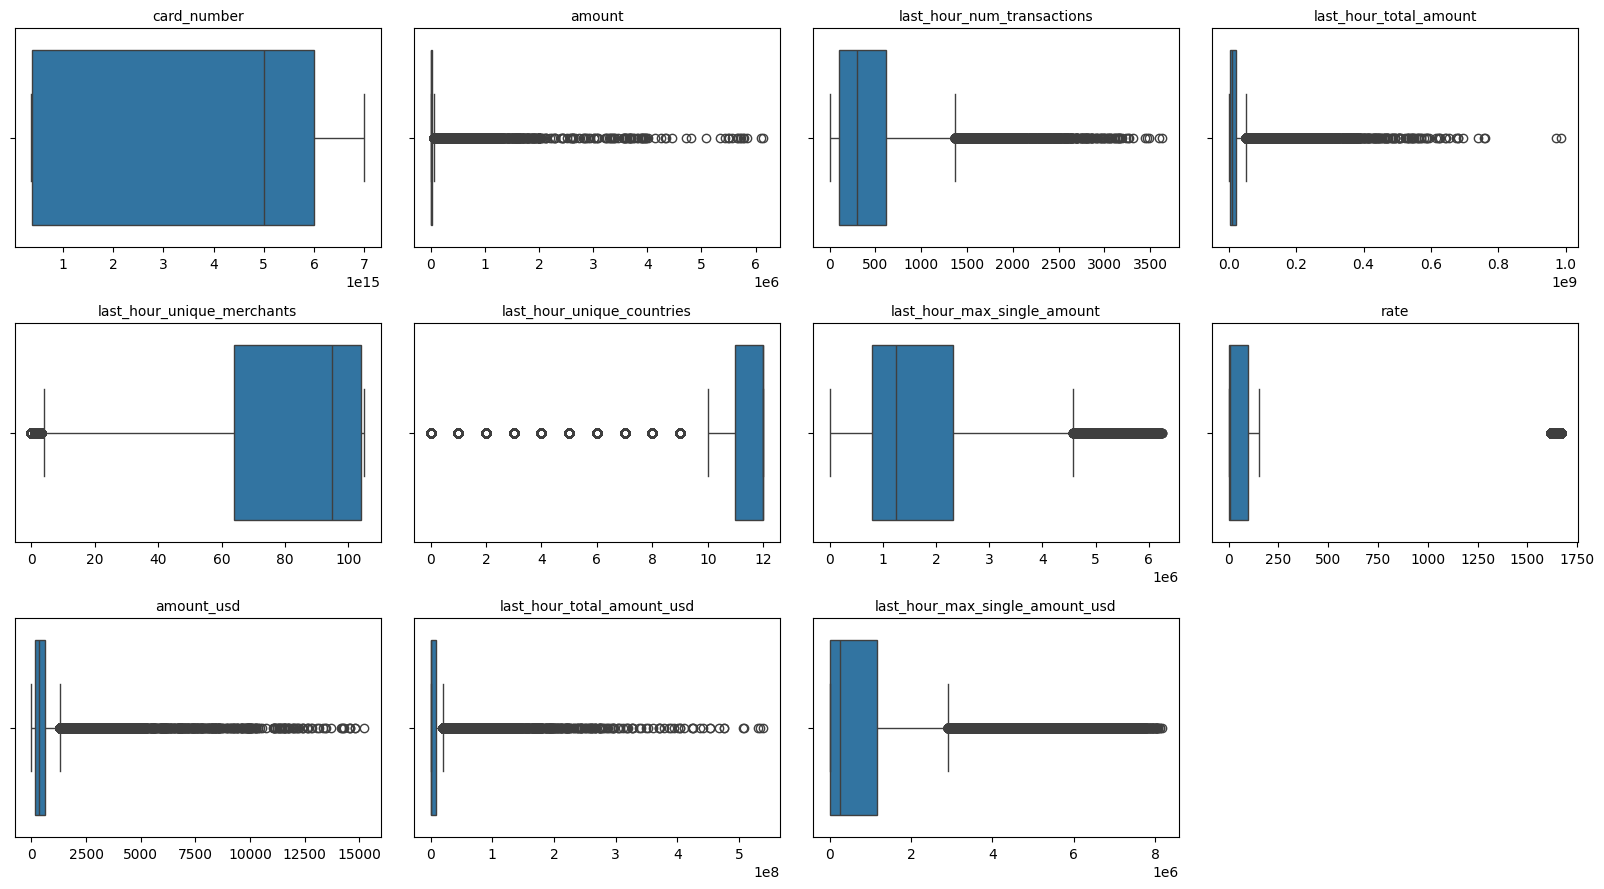

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

num_columns = len(digit_columns)
num_rows = int(np.ceil(num_columns / 4))
num_cols = min(num_columns, 4)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))
axes = axes.flatten()

for i, col in enumerate(digit_columns):
    sns.boxplot(x=df_digit[col].dropna(), ax=axes[i])
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Поиск числовых выбросов IQR, используем стандартное значение 1.5 

In [34]:
import numpy as np

outliers_iqr = pd.DataFrame()
outliers_count_iqr = {}

for col in df_digit.columns:

        Q1 = df_digit[col].quantile(0.25)
        Q3 = df_digit[col].quantile(0.75)

        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        column_outliers = df_digit[(df_digit[col] < lower_bound) | (df_digit[col] > upper_bound)]

        if not column_outliers.empty:
            outliers_count_iqr[col] = column_outliers.shape[0]
            outliers_iqr = pd.concat([outliers_iqr, column_outliers])

outliers_iqr = outliers_iqr.drop_duplicates() # Если одна и та же строка яв. выбросом несколько раз.
# outliers_iqr — это DataFrame с уникальными строками из твоего исходного df_digit, которые содержат хотя бы один выброс по методу IQR.


print(f"Общее количество уникальных строк с выбросами: {outliers_iqr.shape[0]}")
print("\nКоличество выбросов по столбцам:")
for col, count in outliers_count_iqr.items():
    print(f"{col}: {count}")

Общее количество уникальных строк с выбросами: 53845

Количество выбросов по столбцам:
amount: 15284
last_hour_num_transactions: 2656
last_hour_total_amount: 7285
last_hour_unique_merchants: 1637
last_hour_unique_countries: 18385
last_hour_max_single_amount: 6047
rate: 11256
amount_usd: 9767
last_hour_total_amount_usd: 10298
last_hour_max_single_amount_usd: 8306


Форма «виолончели»: отображает распределение значений переменной. Ширина в любом месте показывает плотность (частоту) значений: чем шире, тем больше точек рядом с этим уровнем.

Внутри «коробка» (box): показывает квартильные границы:

Нижняя линия: 25-й перцентиль (Q1)

Средняя линия: медиана

Верхняя линия: 75-й перцентиль (Q3)

Верхняя и нижняя «усы»: показывают диапазон, обычно до 1.5 × IQR, а точки вне этих усов — это выбросы.

Точки за пределами «усов» — это аномально большие или маленькие значения для этой переменной.

Широкая «виолончель» указывает на большую вариативность, узкая — на концентрированные значения.

C:\Users\blue\AppData\Local\Temp\ipykernel_6368\3238395559.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=outliers_normalized,


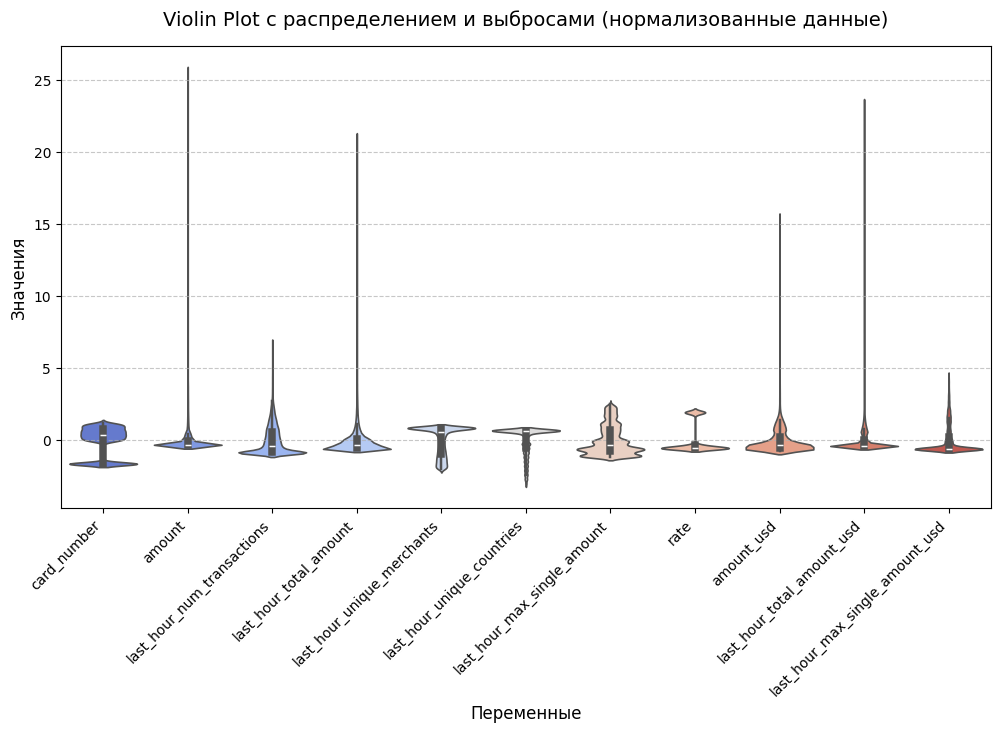

In [35]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

scaler = StandardScaler()
outliers_normalized = pd.DataFrame(scaler.fit_transform(outliers_iqr), columns=outliers_iqr.columns)

plt.figure(figsize=(12, 6))
sns.violinplot(data=outliers_normalized,
               palette="coolwarm",
               inner="box",
               scale="width",
               linewidth=1.2)


plt.xticks(rotation=45, ha='right')
plt.title("Violin Plot с распределением и выбросами (нормализованные данные)", fontsize=14, pad=15)
plt.xlabel("Переменные", fontsize=12)
plt.ylabel("Значения", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




Общие выводы:

Большинство переменных имеют пики около нуля, что указывает на низкую базовую активность или суммы.

Переменные, связанные с суммами (last_hour_amount, last_hour_total_amount, last_hour_max_single_amount), показывают большую вариабельность по сравнению с количественными метриками (card_number, transactions, unique_merchants, unique_countries).


График может использоваться для анализа аномалий, где широкие "хвосты" (например, в last_hour_max_single_amount) могут указывать на необычно крупные транзакции

####
 Обработка категориальных данных
Выводим количество уникальных значений для каждого категориального признака


In [36]:
unique_counts = df[cat_cols].nunique().sort_values()
unique_counts.columns = ['Кол-во уникальных значений']
print(unique_counts)

city_size                    2
is_weekend                   2
is_outside_home_country      2
is_fraud                     2
is_high_risk_vendor          2
is_card_present              2
channel                      3
card_type                    5
vendor_category              8
device                       9
currency                    11
city                        11
country                     12
vendor_type                 17
vendor                     105
dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Инициализация LabelEncoder для бинарных переменных
label_encoder = LabelEncoder()

# Преобразование бинарных переменных (True/False или Yes/No)
binary_cols = [
    'is_card_present',
    'is_outside_home_country',
    'is_high_risk_vendor',
    'is_weekend',
    'is_fraud'
]

for col in binary_cols:
    df[col] = label_encoder.fit_transform(df[col])


In [38]:
import pandas as pd

# Преобразование номинальных переменных
cat_cols = [
    'vendor_category', 'vendor_type', 'vendor', 'currency', 'country', 'city',
    'card_type', 'device', 'channel'
]

# Применяем One-Hot Encoding и удаляем первый столбец каждой категории
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(df)

      transaction_id customer_id       card_number                  timestamp  \
0        TX_57ad062a  CUST_92468   373501928102413 2024-10-25 03:00:38.793644   
1        TX_764c33f8  CUST_12061  4711046379064244 2024-10-09 19:51:20.774278   
2        TX_81884319  CUST_64361   379739229741414 2024-10-30 06:02:17.529689   
3        TX_9c5ee0e8  CUST_44952  6935120177137067 2024-10-21 14:56:48.578842   
4        TX_b74cba7a  CUST_26961  4973804196225809 2024-10-24 09:42:43.148946   
...              ...         ...               ...                        ...   
99994    TX_345ccdc8  CUST_29487  5394371560115618 2024-10-05 11:44:35.028704   
99995    TX_52649641  CUST_79612   371088426186751 2024-10-09 19:15:03.003580   
99996    TX_ff18db3d  CUST_79361  6219138778768079 2024-10-23 16:41:51.932871   
99997    TX_13ec6aeb  CUST_48557  6361936298102323 2024-10-07 06:18:48.722154   
99998    TX_75f3c15c  CUST_85448  5619083831176126 2024-10-24 11:03:44.539576   

         amount city_size  

In [39]:
from scipy.stats import shapiro, anderson
import pandas as pd

def test_norm(df):
    # Выбор всех числовых столбцов (int64, float64)
    digit_columns = df.select_dtypes(include=['int64', 'float64']).columns

    results = []
    for col in digit_columns:
        data = df[col].dropna()  # Удаляем NaN для тестов
        if len(data) > 3:  # Минимальное количество для теста
            _, p_shapiro = shapiro(data)
            result_anderson = anderson(data)

            results.append({
                'Feature': col,
                'Shapiro p-value': p_shapiro,
                'Anderson stat': result_anderson.statistic,
                'Anderson crit_vals': result_anderson.critical_values,
                'Anderson significance_levels': result_anderson.significance_level
            })

    for res in results:
        print(f"  Feature: {res['Feature']}")
        print(f"  Shapiro-Wilk p-value: {res['Shapiro p-value']:.4f}")
        print(f"  Anderson-Darling statistic: {res['Anderson stat']:.4f}")
        print(f"  Anderson critical values: {res['Anderson crit_vals']}")
        print(f"  Anderson significance levels: {res['Anderson significance_levels']}")
        print()

# Применение функции
test_norm(df)

d:\Python Language\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 99999.
  res = hypotest_fun_out(*samples, **kwds)


  Feature: card_number
  Shapiro-Wilk p-value: 0.0000
  Anderson-Darling statistic: 8343.4566
  Anderson critical values: [0.576 0.656 0.787 0.918 1.092]
  Anderson significance levels: [15.  10.   5.   2.5  1. ]

  Feature: amount
  Shapiro-Wilk p-value: 0.0000
  Anderson-Darling statistic: 23958.3289
  Anderson critical values: [0.576 0.656 0.787 0.918 1.092]
  Anderson significance levels: [15.  10.   5.   2.5  1. ]

  Feature: is_card_present
  Shapiro-Wilk p-value: 0.0000
  Anderson-Darling statistic: 33842.7340
  Anderson critical values: [0.576 0.656 0.787 0.918 1.092]
  Anderson significance levels: [15.  10.   5.   2.5  1. ]

  Feature: is_outside_home_country
  Shapiro-Wilk p-value: 0.0000
  Anderson-Darling statistic: 21029.4672
  Anderson critical values: [0.576 0.656 0.787 0.918 1.092]
  Anderson significance levels: [15.  10.   5.   2.5  1. ]

  Feature: is_high_risk_vendor
  Shapiro-Wilk p-value: 0.0000
  Anderson-Darling statistic: 23951.0266
  Anderson critical values:

Для всех переменных p-value равно 0.0000 (менее 0.05). Это указывает на то, что для каждого столбца на уровне значимости 5% гипотеза о нормальности распределения отклоняется. Другими словами, ни одна из проверяемых переменных не следует нормальному распределению.

In [40]:
import numpy as np

# Список столбцов с выбросами для логарифмического преобразования
log_columns = [
    'amount',
    'last_hour_num_transactions',
    'last_hour_total_amount',
    'last_hour_unique_merchants',
    'last_hour_unique_countries',
    'last_hour_max_single_amount'
]

# Применение логарифмического преобразования (np.log1p добавляет 1 перед логарифмом, чтобы избежать log(0))
df[log_columns] = np.log1p(df[log_columns])

# Проверка результатов (опционально)
print(df[log_columns].head())

      amount  last_hour_num_transactions  last_hour_total_amount  \
0   7.442182                    5.703782               16.292679   
1   4.288814                    6.748760               16.885030   
2   4.042349                    3.044522               12.015891   
3   6.669371                    5.468060               16.519655   
4  10.590109                    5.123964               15.525127   

   last_hour_unique_merchants  last_hour_unique_countries  \
0                    4.564348                    2.564949   
1                    4.663439                    2.564949   
2                    2.944439                    2.079442   
3                    4.488636                    2.564949   
4                    4.317488                    2.564949   

   last_hour_max_single_amount  
0                    13.844700  
1                    14.244094  
2                    11.892871  
3                    13.829555  
4                    13.480524  


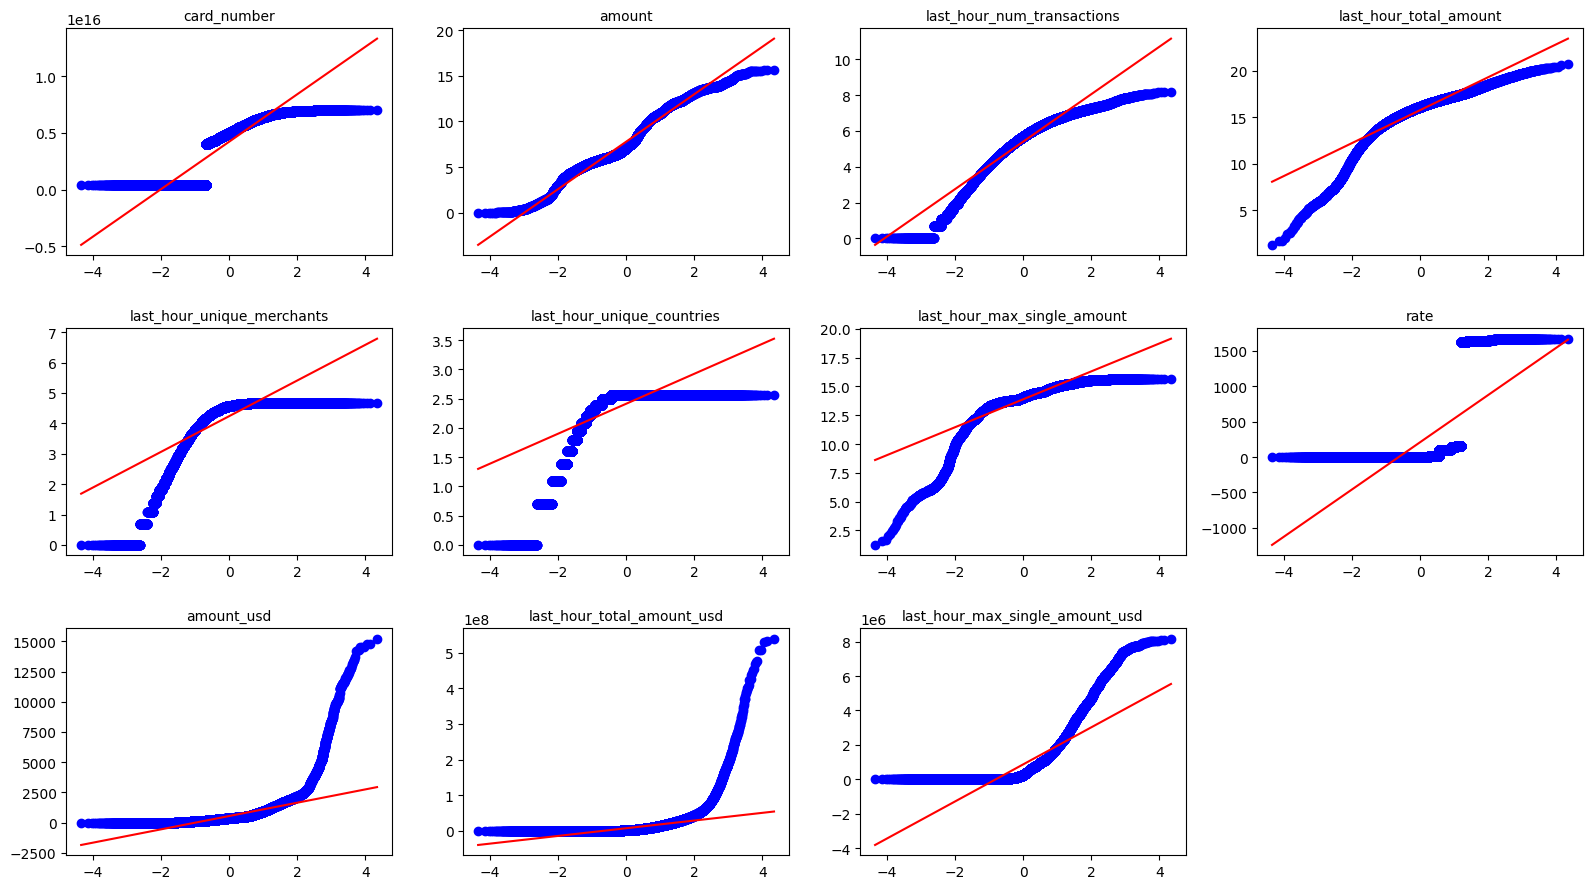

In [41]:
import numpy as np
import matplotlib.pyplot as plt


num_columns = len(df_digit.columns)
num_rows = int(np.ceil(num_columns / 4))
num_cols = min(num_columns, 4)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))
axes = axes.flatten()

for i, col in enumerate(df_digit.columns):
    stats.probplot(df[col], dist="norm", plot=axes[i])
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


3 4


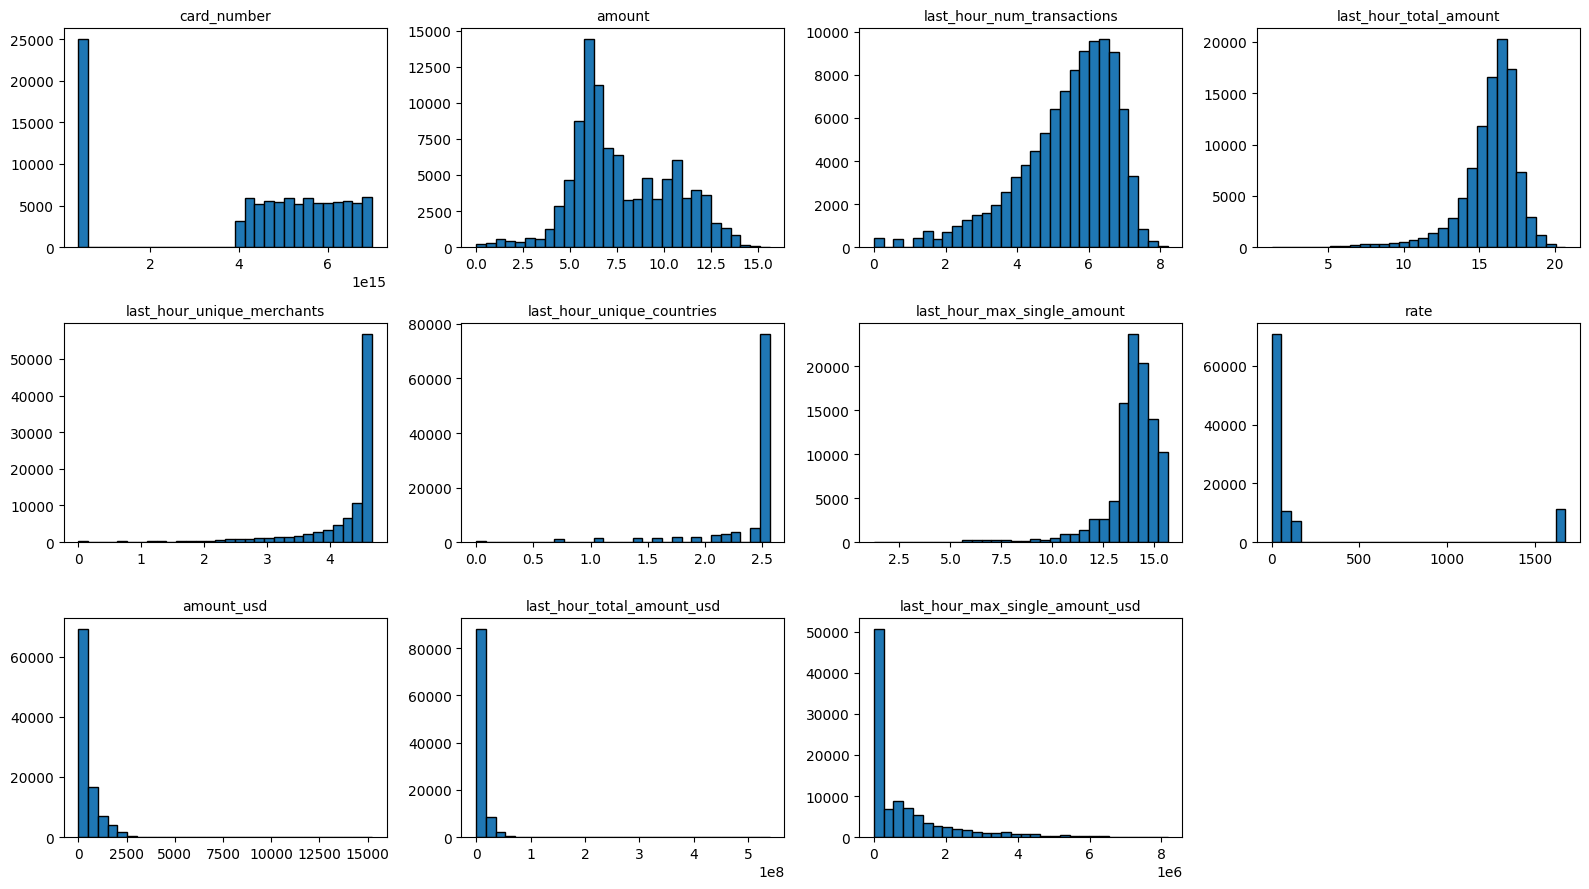

In [42]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


num_columns = len(df_digit.columns)
num_rows = int(np.ceil(num_columns / 4))
num_cols = min(num_columns, 4)
print(num_rows, num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))
axes = axes.flatten()

for i, col in enumerate(df_digit.columns):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [43]:
import pandas as pd
import scipy.stats as stats
import numpy as np

def kolmogorov_test(df):
    ks_results = []

    for column in df.columns:
        data = df[column].dropna()

        data = data[data > 0]
        if data.empty:
            continue

        log_data = np.log(data)
        stat_ks, p_value_ks = stats.kstest(log_data, 'norm', args=(log_data.mean(), log_data.std()))

        ks_results.append({
            'column': column,
            'KS-statistic': stat_ks,
            'p-value': p_value_ks
        })

    return pd.DataFrame(ks_results)

ks_results_df = kolmogorov_test(df_digit[df_digit.columns])
print(ks_results_df.sort_values(by="p-value", ascending=True))


                             column  KS-statistic  p-value
0                       card_number      0.372172      0.0
1                            amount      0.106014      0.0
2        last_hour_num_transactions      0.086243      0.0
3            last_hour_total_amount      0.107479      0.0
4        last_hour_unique_merchants      0.282101      0.0
5        last_hour_unique_countries      0.346328      0.0
6       last_hour_max_single_amount      0.178531      0.0
7                              rate      0.256532      0.0
8                        amount_usd      0.149851      0.0
9        last_hour_total_amount_usd      0.079017      0.0
10  last_hour_max_single_amount_usd      0.132970      0.0


Категории

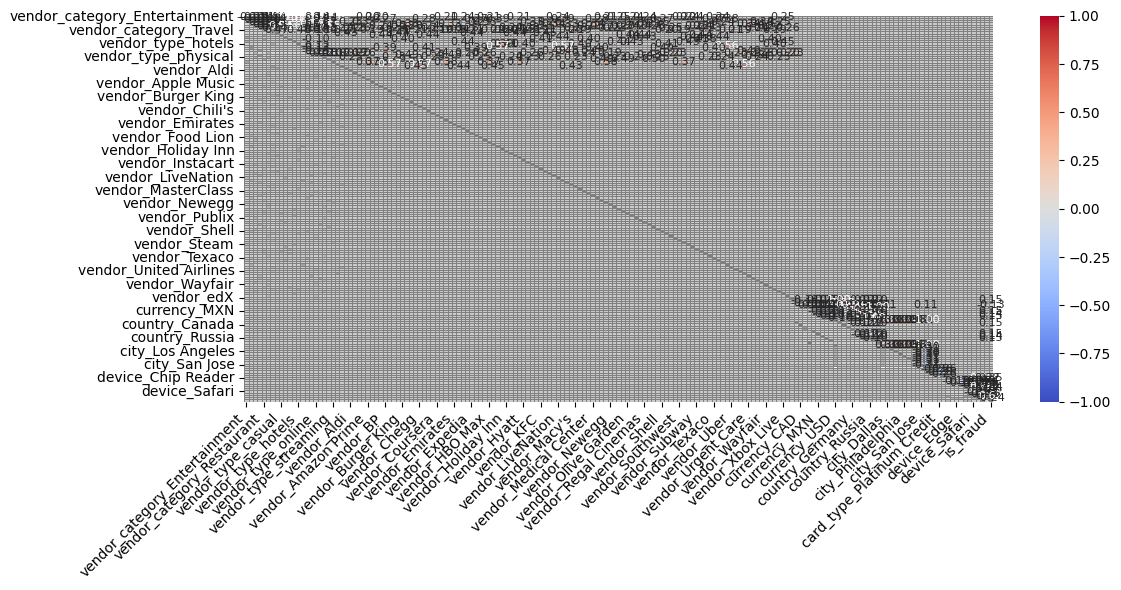

currency_BRL - is_fraud: 0.15
currency_EUR - is_fraud: -0.13
currency_MXN - is_fraud: 0.15
currency_NGN - is_fraud: 0.14
currency_RUB - is_fraud: 0.15
country_Brazil - is_fraud: 0.15
country_Mexico - is_fraud: 0.15
country_Nigeria - is_fraud: 0.14
country_Russia - is_fraud: 0.15
device_Chip Reader - is_fraud: 0.35
device_Magnetic Stripe - is_fraud: 0.34
device_NFC Payment - is_fraud: 0.35
channel_pos - is_fraud: 0.62
channel_web - is_fraud: -0.24


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

shield = 0.4

# Берём только бинарные колонки типа bool
cat_bin_cols = [col for col in df.columns if df[col].dtype == 'bool']

# Добавляем целевую переменную
if 'is_fraud' not in cat_bin_cols:
    cat_bin_cols.append('is_fraud')

df_binary = df[cat_bin_cols].astype(int)  # переводим bool в 0/1

# Корреляционная матрица Спирмена
corr_matrix = df_binary.corr(method='spearman')

# Выбираем сильные корреляции
mask_strong = (np.abs(corr_matrix) > shield).values
np.fill_diagonal(mask_strong, False)
strong_vars = corr_matrix.columns[mask_strong.any(axis=1)].tolist()

df_filtered_binary = df_binary[strong_vars]
filtered_corr = df_filtered_binary.corr(method='spearman')

mask_weak = np.abs(filtered_corr) < shield
mask_triangle = np.tril(np.ones(filtered_corr.shape), k=0).astype(bool)
mask = mask_weak | mask_triangle

np.fill_diagonal(filtered_corr.values, np.nan)

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, cmap='Greys', annot=False, cbar=False, alpha=0.5)
sns.heatmap(filtered_corr, cmap='coolwarm', annot=True, fmt='.2f', alpha=1,
            mask=mask, linewidths=0.5, linecolor='gray', annot_kws={"size": 8}, cbar=True)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Сильные корреляции с целевой переменной
for col in df_binary.columns:
    if col != 'is_fraud':
        corr_val = corr_matrix.loc[col, 'is_fraud']
        if abs(corr_val) > shield:
            print(f"{col} - is_fraud: {corr_val:.2f}")


<small>

1️⃣ Валюты (currency_*)
currency_BRL, currency_EUR, currency_MXN, currency_NGN, currency_RUB — это one-hot кодирование валют транзакций:
Если currency_BRL = 1, значит транзакция в бразильских реалах.
И так далее для каждой валюты.
Корреляция со is_fraud:
currency_BRL - is_fraud: 0.15 → небольшая положительная связь: транзакции в BRL чуть чаще мошеннические.
currency_EUR - is_fraud: -0.13 → транзакции в евро чуть реже мошеннические.

2️⃣ Страны (country_*)
country_Brazil, country_Mexico, country_Nigeria, country_Russia — аналогично, one-hot кодирование стран.
Положительная корреляция (~0.14–0.15) означает, что транзакции из этих стран немного чаще являются мошенническими.

3️⃣ Устройства (device_*)
device_Chip Reader, device_Magnetic Stripe, device_NFC Payment — тип устройства, с которого сделана транзакция:
Chip Reader = считыватель чип-карт
Magnetic Stripe = магнитная полоса
NFC Payment = бесконтактная оплата

Корреляции ~0.34–0.35 → достаточно сильная положительная связь: транзакции через эти устройства чаще помечаются как мошенничество.

4️⃣ Каналы (channel_*)
channel_pos — POS-терминал (точка продаж)
channel_web — онлайн-платформа / веб
Корреляция со is_fraud:
channel_pos - is_fraud: 0.62 → транзакции через POS очень часто мошеннические.
channel_web - is_fraud: -0.24 → веб-транзакции меньше связаны с мошенничеством.

Числа

In [ ]:
df_numeric = df_digit.copy()  # твой числовой df
df_numeric['is_fraud'] = df['is_fraud']
df_digit_corr = df_numeric.copy()

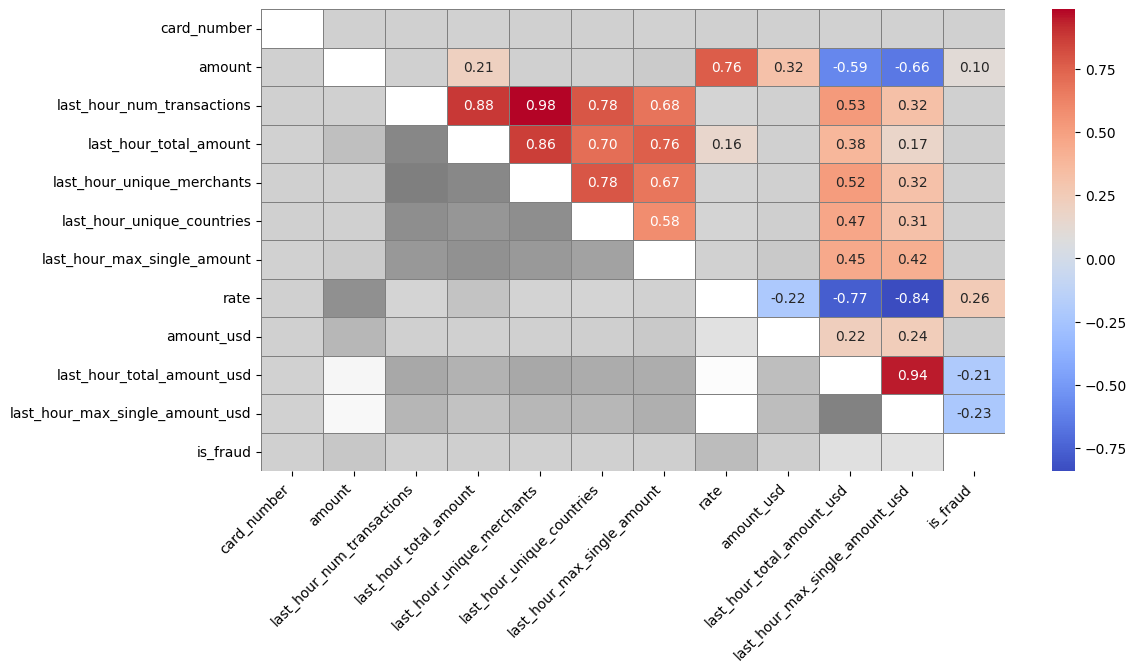

amount - is_fraud: 0.10
rate - is_fraud: 0.26
last_hour_total_amount_usd - is_fraud: -0.21
last_hour_max_single_amount_usd - is_fraud: -0.23


In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
shield = 0.1

corr_matrix = df_digit_corr.corr(method='spearman')
mask_weak = np.abs(corr_matrix) < shield
mask_triangle = np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool)
mask = mask_weak | mask_triangle

np.fill_diagonal(corr_matrix.values, np.nan)
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, cmap='Greys', annot=False, cbar=False, alpha=0.5)
sns.heatmap(corr_matrix, mask=mask, annot=True, linewidths=0.5, linecolor='gray', cmap='coolwarm', fmt='.2f', alpha=1)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > shield:
            if corr_matrix.columns[i] == 'is_fraud' or corr_matrix.columns[j] == 'is_fraud':
                print(f"{corr_matrix.columns[i]} - {corr_matrix.columns[j]}: {corr_val:.2f}")